In [2]:
import torch
import torch.nn as nn
import torchvision

import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage.interpolation import rotate
import numpy as np

from IPython.display import HTML
from IPython.display import clear_output
import torch.nn as nn
import torch.nn.functional as F
import torch
from functools import partial
from torch.utils.data import DataLoader, TensorDataset

In [3]:
def conv3x3(in_planes, out_planes, stride=1, bias=False):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=bias)


def conv1x1(in_planes, out_planes, stride=1, bias=False):
    "1x1 convolution"
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                     padding=0, bias=bias)


def dilated_conv3x3(in_planes, out_planes, dilation, bias=True):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, padding=dilation, dilation=dilation, bias=bias)

class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features, num_classes, bias=True):
        super().__init__()
        self.num_features = num_features
        self.bias = bias
        self.bn = nn.BatchNorm2d(num_features, affine=False)
        if self.bias:
            self.embed = nn.Embedding(num_classes, num_features * 2)
            self.embed.weight.data[:, :num_features].uniform_()  # Initialise scale at N(1, 0.02)
            self.embed.weight.data[:, num_features:].zero_()  # Initialise bias at 0
        else:
            self.embed = nn.Embedding(num_classes, num_features)
            self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.bn(x)
        if self.bias:
            gamma, beta = self.embed(y).chunk(2, dim=1)
            out = gamma.view(-1, self.num_features, 1, 1) * out + beta.view(-1, self.num_features, 1, 1)
        else:
            gamma = self.embed(y)
            out = gamma.view(-1, self.num_features, 1, 1) * out
        return out

class ConditionalInstanceNorm2d(nn.Module):
    def __init__(self, num_features, num_classes, bias=True):
        super().__init__()
        self.num_features = num_features
        self.bias = bias
        self.instance_norm = nn.InstanceNorm2d(num_features, affine=False, track_running_stats=False)
        if bias:
            self.embed = nn.Embedding(num_classes, num_features * 2)
            self.embed.weight.data[:, :num_features].uniform_()  # Initialise scale at N(1, 0.02)
            self.embed.weight.data[:, num_features:].zero_()  # Initialise bias at 0
        else:
            self.embed = nn.Embedding(num_classes, num_features)
            self.embed.weight.data.uniform_()

    def forward(self, x, y):
        h = self.instance_norm(x)
        if self.bias:
            gamma, beta = self.embed(y).chunk(2, dim=-1)
            out = gamma.view(-1, self.num_features, 1, 1) * h + beta.view(-1, self.num_features, 1, 1)
        else:
            gamma = self.embed(y)
            out = gamma.view(-1, self.num_features, 1, 1) * h
        return out

class CRPBlock(nn.Module):
    def __init__(self, features, n_stages, act=nn.ReLU()):
        super().__init__()
        self.convs = nn.ModuleList()
        for i in range(n_stages):
            self.convs.append(conv3x3(features, features, stride=1, bias=False))
        self.n_stages = n_stages
        self.maxpool = nn.MaxPool2d(kernel_size=5, stride=1, padding=2)
        self.act = act

    def forward(self, x):
        x = self.act(x)
        path = x
        for i in range(self.n_stages):
            path = self.maxpool(path)
            path = self.convs[i](path)
            x = path + x
        return x

class CondCRPBlock(nn.Module):
    def __init__(self, features, n_stages, num_classes, normalizer, act=nn.ReLU()):
        super().__init__()
        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        for i in range(n_stages):
            self.norms.append(normalizer(features, num_classes, bias=True))
            self.convs.append(conv3x3(features, features, stride=1, bias=False))
        self.n_stages = n_stages
        self.maxpool = nn.AvgPool2d(kernel_size=5, stride=1, padding=2)
        self.act = act

    def forward(self, x, y):
        x = self.act(x)
        path = x
        for i in range(self.n_stages):
            path = self.norms[i](path, y)
            path = self.maxpool(path)
            path = self.convs[i](path)
            x = path + x
        return x

class CondRCUBlock(nn.Module):
    def __init__(self, features, n_blocks, n_stages, num_classes, normalizer, act=nn.ReLU()):
        super().__init__()

        for i in range(n_blocks):
            for j in range(n_stages):
                setattr(self, '{}_{}_norm'.format(i + 1, j + 1), normalizer(features, num_classes, bias=True))
                setattr(self, '{}_{}_conv'.format(i + 1, j + 1),
                        conv3x3(features, features, stride=1, bias=False))

        self.stride = 1
        self.n_blocks = n_blocks
        self.n_stages = n_stages
        self.act = act

    def forward(self, x, y):
        for i in range(self.n_blocks):
            residual = x
            for j in range(self.n_stages):
                x = getattr(self, '{}_{}_norm'.format(i + 1, j + 1))(x, y)
                x = self.act(x)
                x = getattr(self, '{}_{}_conv'.format(i + 1, j + 1))(x)
            x += residual
        return x

class CondMSFBlock(nn.Module):
    def __init__(self, in_planes, features, num_classes, normalizer):
        """
        :param in_planes: tuples of input planes
        """
        super().__init__()
        assert isinstance(in_planes, list) or isinstance(in_planes, tuple)

        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.features = features

        for i in range(len(in_planes)):
            self.convs.append(conv3x3(in_planes[i], features, stride=1, bias=True))
            self.norms.append(normalizer(in_planes[i], num_classes, bias=True))

    def forward(self, xs, y, shape):
        sums = torch.zeros(xs[0].shape[0], self.features, *shape, device=xs[0].device)
        for i in range(len(self.convs)):
            h = self.norms[i](xs[i], y)
            h = self.convs[i](h)
            h = F.interpolate(h, size=shape, mode='bilinear', align_corners=True)
            sums += h
        return sums

class CondRefineBlock(nn.Module):
    def __init__(self, in_planes, features, num_classes, normalizer, act=nn.ReLU(), start=False, end=False):
        super().__init__()

        assert isinstance(in_planes, tuple) or isinstance(in_planes, list)
        self.n_blocks = n_blocks = len(in_planes)

        self.adapt_convs = nn.ModuleList()
        for i in range(n_blocks):
            self.adapt_convs.append(
                CondRCUBlock(in_planes[i], 2, 2, num_classes, normalizer, act)
            )

        self.output_convs = CondRCUBlock(features, 3 if end else 1, 2, num_classes, normalizer, act)

        if not start:
            self.msf = CondMSFBlock(in_planes, features, num_classes, normalizer)

        self.crp = CondCRPBlock(features, 2, num_classes, normalizer, act)

    def forward(self, xs, y, output_shape):
        assert isinstance(xs, tuple) or isinstance(xs, list)
        hs = []
        for i in range(len(xs)):
            h = self.adapt_convs[i](xs[i], y)
            hs.append(h)

        if self.n_blocks > 1:
            h = self.msf(hs, y, output_shape)
        else:
            h = hs[0]

        h = self.crp(h, y)
        h = self.output_convs(h, y)

        return h
    
class ConvMeanPool(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size=3, biases=True, adjust_padding=False):
        super().__init__()
        if not adjust_padding:
            self.conv = nn.Conv2d(input_dim, output_dim, kernel_size, stride=1, padding=kernel_size // 2, bias=biases)
        else:
            self.conv = nn.Sequential(
                nn.ZeroPad2d((1, 0, 1, 0)),
                nn.Conv2d(input_dim, output_dim, kernel_size, stride=1, padding=kernel_size // 2, bias=biases)
            )

    def forward(self, inputs):
        output = self.conv(inputs)
        output = sum(
            [output[:, :, ::2, ::2], output[:, :, 1::2, ::2], output[:, :, ::2, 1::2], output[:, :, 1::2, 1::2]]) / 4.
        return output


class MeanPoolConv(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size=3, biases=True):
        super().__init__()
        self.conv = nn.Conv2d(input_dim, output_dim, kernel_size, stride=1, padding=kernel_size // 2, bias=biases)

    def forward(self, inputs):
        output = inputs
        output = sum(
            [output[:, :, ::2, ::2], output[:, :, 1::2, ::2], output[:, :, ::2, 1::2], output[:, :, 1::2, 1::2]]) / 4.
        return self.conv(output)


class UpsampleConv(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size=3, biases=True):
        super().__init__()
        self.conv = nn.Conv2d(input_dim, output_dim, kernel_size, stride=1, padding=kernel_size // 2, bias=biases)
        self.pixelshuffle = nn.PixelShuffle(upscale_factor=2)

    def forward(self, inputs):
        output = inputs
        output = torch.cat([output, output, output, output], dim=1)
        output = self.pixelshuffle(output)
        return self.conv(output)

class ConditionalResidualBlock(nn.Module):
    def __init__(self, input_dim, output_dim, num_classes, resample=None, act=nn.ELU(),
                 normalization=ConditionalBatchNorm2d, adjust_padding=False, dilation=None):
        super().__init__()
        self.non_linearity = act
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.resample = resample
        if resample == 'down':
            if dilation is not None:
                self.conv1 = dilated_conv3x3(input_dim, input_dim, dilation=dilation)
                self.normalize2 = normalization(input_dim, num_classes)
                self.conv2 = dilated_conv3x3(input_dim, output_dim, dilation=dilation)
                conv_shortcut = partial(dilated_conv3x3, dilation=dilation)
            else:
                self.conv1 = nn.Conv2d(input_dim, input_dim, 3, stride=1, padding=1)
                self.normalize2 = normalization(input_dim, num_classes)
                self.conv2 = ConvMeanPool(input_dim, output_dim, 3, adjust_padding=adjust_padding)
                conv_shortcut = partial(ConvMeanPool, kernel_size=1, adjust_padding=adjust_padding)

        elif resample is None:
            if dilation is not None:
                conv_shortcut = partial(dilated_conv3x3, dilation=dilation)
                self.conv1 = dilated_conv3x3(input_dim, output_dim, dilation=dilation)
                self.normalize2 = normalization(output_dim, num_classes)
                self.conv2 = dilated_conv3x3(output_dim, output_dim, dilation=dilation)
            else:
                conv_shortcut = nn.Conv2d
                self.conv1 = nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=1, padding=1)
                self.normalize2 = normalization(output_dim, num_classes)
                self.conv2 = nn.Conv2d(output_dim, output_dim, kernel_size=3, stride=1, padding=1)
        else:
            raise Exception('invalid resample value')

        if output_dim != input_dim or resample is not None:
            self.shortcut = conv_shortcut(input_dim, output_dim)

        self.normalize1 = normalization(input_dim, num_classes)

    def forward(self, x, y):
        output = self.normalize1(x, y)
        output = self.non_linearity(output)
        output = self.conv1(output)
        output = self.normalize2(output, y)
        output = self.non_linearity(output)
        output = self.conv2(output)

        if self.output_dim == self.input_dim and self.resample is None:
            shortcut = x
        else:
            shortcut = self.shortcut(x)

        return shortcut + output

class ConditionalInstanceNorm2dPlus(nn.Module):
    def __init__(self, num_features, num_classes, bias=True):
        super().__init__()
        self.num_features = num_features
        self.bias = bias
        self.instance_norm = nn.InstanceNorm2d(num_features, affine=False, track_running_stats=False)
        if bias:
            self.embed = nn.Embedding(num_classes, num_features * 3)
            self.embed.weight.data[:, :2 * num_features].normal_(1, 0.02)  # Initialise scale at N(1, 0.02)
            self.embed.weight.data[:, 2 * num_features:].zero_()  # Initialise bias at 0
        else:
            self.embed = nn.Embedding(num_classes, 2 * num_features)
            self.embed.weight.data.normal_(1, 0.02)

    def forward(self, x, y):
        means = torch.mean(x, dim=(2, 3))
        m = torch.mean(means, dim=-1, keepdim=True)
        v = torch.var(means, dim=-1, keepdim=True)
        means = (means - m) / (torch.sqrt(v + 1e-5))
        h = self.instance_norm(x)

        if self.bias:
            gamma, alpha, beta = self.embed(y).chunk(3, dim=-1)
            h = h + means[..., None, None] * alpha[..., None, None]
            out = gamma.view(-1, self.num_features, 1, 1) * h + beta.view(-1, self.num_features, 1, 1)
        else:
            gamma, alpha = self.embed(y).chunk(2, dim=-1)
            h = h + means[..., None, None] * alpha[..., None, None]
            out = gamma.view(-1, self.num_features, 1, 1) * h
        return out
    
class CondRefineNetDilated(nn.Module):
    def __init__(self,  device, L):
        super().__init__()
        # self.norm = ConditionalInstanceNorm2d
        self.norm = ConditionalInstanceNorm2dPlus
        self.ngf = 64
        self.num_classes = L
        self.act = act = nn.ELU()
        self.device = device
        # self.act = act = nn.ReLU(True)

        # self.begin_conv = nn.Conv2d(1, self.ngf, 3, stride=1, padding=1)
        self.begin_conv = nn.Conv2d(4, self.ngf, 3, stride=1, padding=1)
        self.normalizer = self.norm(self.ngf, self.num_classes)

        # self.end_conv = nn.Conv2d(self.ngf, 1, 3, stride=1, padding=1)
        self.end_conv = nn.Conv2d(self.ngf, 4, 3, stride=1, padding=1)

        
        self.res1 = nn.ModuleList([
            ConditionalResidualBlock(self.ngf, self.ngf, self.num_classes, resample=None, act=act,
                                     normalization=self.norm),
            ConditionalResidualBlock(self.ngf, self.ngf, self.num_classes, resample=None, act=act,
                                     normalization=self.norm)]
        )

        self.res2 = nn.ModuleList([
            ConditionalResidualBlock(self.ngf, 2 * self.ngf, self.num_classes, resample='down', act=act,
                                     normalization=self.norm),
            ConditionalResidualBlock(2 * self.ngf, 2 * self.ngf, self.num_classes, resample=None, act=act,
                                     normalization=self.norm)]
        )

        self.res3 = nn.ModuleList([
            ConditionalResidualBlock(2 * self.ngf, 2 * self.ngf, self.num_classes, resample='down', act=act,
                                     normalization=self.norm, dilation=2),
            ConditionalResidualBlock(2 * self.ngf, 2 * self.ngf, self.num_classes, resample=None, act=act,
                                     normalization=self.norm, dilation=2)]
        )

        self.res4 = nn.ModuleList([
            ConditionalResidualBlock(2 * self.ngf, 2 * self.ngf, self.num_classes, resample='down', act=act,
                                     normalization=self.norm, adjust_padding=True, dilation=4),
            ConditionalResidualBlock(2 * self.ngf, 2 * self.ngf, self.num_classes, resample=None, act=act,
                                     normalization=self.norm, dilation=4)]
        )


        self.refine1 = CondRefineBlock([2 * self.ngf], 2 * self.ngf, self.num_classes, self.norm, act=act, start=True)
        self.refine2 = CondRefineBlock([2 * self.ngf, 2 * self.ngf], 2 * self.ngf, self.num_classes, self.norm, act=act)
        self.refine3 = CondRefineBlock([2 * self.ngf, 2 * self.ngf], self.ngf, self.num_classes, self.norm, act=act)
        self.refine4 = CondRefineBlock([self.ngf, self.ngf], self.ngf, self.num_classes, self.norm, act=act, end=True)
        
        self.to(device = device)

    def _compute_cond_module(self, module, x, y):
        for m in module:
            x = m(x, y)
        return x

    def forward(self, x, y):
        output = self.begin_conv(x)

        layer1 = self._compute_cond_module(self.res1, output, y)
        layer2 = self._compute_cond_module(self.res2, layer1, y)
        layer3 = self._compute_cond_module(self.res3, layer2, y)
        layer4 = self._compute_cond_module(self.res4, layer3, y)

        ref1 = self.refine1([layer4], y, layer4.shape[2:])
        ref2 = self.refine2([layer3, ref1], y, layer3.shape[2:])
        ref3 = self.refine3([layer2, ref2], y, layer2.shape[2:])
        output = self.refine4([layer1, ref3], y, layer1.shape[2:])

        output = self.normalizer(output, y)
        output = self.act(output)
        output = self.end_conv(output)
        return output

In [4]:
class Model(nn.Module):
    def __init__(self, device, n_steps, sigma_min, sigma_max):
        '''
        Score Network.

        n_steps   : perturbation schedule steps (Langevin Dynamic step)
        sigma_min : sigma min of perturbation schedule
        sigma_min : sigma max of perturbation schedule

        '''
        super().__init__()
        self.device = device
        self.sigmas = torch.exp(torch.linspace(start=math.log(sigma_max), end=math.log(sigma_min), steps = n_steps)).to(device = device)
        self.conv_layer = CondRefineNetDilated(device, n_steps)
        self.to(device = device)

    # Loss Function
    def loss_fn(self, x, idx=None):
        '''
        This function performed when only training phase.

        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.

        '''
        scores, target, sigma = self.forward(x, idx=idx, get_target=True)
        target = target.view(target.shape[0], -1)
        scores = scores.view(scores.shape[0], -1)        
        losses = torch.square(scores - target).mean(dim=-1) * sigma.squeeze() ** 2
        return losses.mean(dim=0)

    # S(theta, sigma)
    def forward(self, x, idx=None, get_target=False):
        '''
        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.
        get_target : if True (training phase), target and sigma is returned with output (score prediction)

        '''

        if idx == None:
            idx = torch.randint(0, len(self.sigmas), (x.size(0), 1)).to(device = self.device)
            used_sigmas = self.sigmas[idx][:, :, None, None]
            noise = torch.randn_like(x)
            x_tilde = x + noise * used_sigmas
            idx = idx.squeeze()
        else:
            idx = torch.Tensor([idx for _ in range(x.size(0))]).to(device = self.device).long()
            x_tilde = x
            
        if get_target:
            target = - 1 / (used_sigmas ) * noise 

            
        output = self.conv_layer(x_tilde, idx)

        return (output, target, used_sigmas) if get_target else output

In [5]:
class AnnealedLangevinDynamic():
    def __init__(self, sigma_min, sigma_max, n_steps, annealed_step, score_fn, device, eps = 1e-1):
        '''
        sigma_min : minimum sigmas of perturbation schedule 
        sigma_max : maximum sigmas of perturbation schedule 
        L         : iteration step of Langevin dynamic
        T         : annelaed step of annealed Langevin dynamic
        score_fn  : trained score network
        eps       : coefficient of step size
        '''
        self.process = torch.exp(torch.linspace(start=math.log(sigma_max), end=math.log(sigma_min), steps = n_steps))
        self.step_size = eps * (self.process / self.process[-1] ) ** 2
        self.score_fn = score_fn
        self.annealed_step = annealed_step
        self.device = device
        
    # One iteration of annealed step
    def _one_annealed_step_iteration(self, x, idx):
        '''
        x   : perturbated data
        idx : step of perturbation schedule
        '''
        self.score_fn.eval()
        z, step_size = torch.randn_like(x).to(device = self.device), self.step_size[idx]
        x = x + 0.5 * step_size * self.score_fn(x, idx) + torch.sqrt(step_size) * z
        return x
        
    # One annealed step
    def _one_annealed_step(self, x, idx):
        '''
        x   : perturbated data
        idx : step of perturbation schedule
        '''
        for _ in range(self.annealed_step):
            x = self._one_annealed_step_iteration(x, idx)
        return x
        
    # One Langevin Step
    def _one_diffusion_step(self, x):
        '''
        x   : sampling of prior distribution
        '''
        for idx in range(len(self.process)):
            x = self._one_annealed_step(x, idx)
            yield x

    @torch.no_grad()
    def sampling(self, sampling_number, only_final=False):
        '''
        only_final : If True, return is an only output of final schedule step 
        '''
        # sample = torch.rand([sampling_number, 1, 14, 14]).to(device = self.device)
        sample = torch.rand([sampling_number, 4, 64, 64]).to(device = self.device)
        sampling_list = []
        
        final = None
        for sample in self._one_diffusion_step(sample):
            final = sample
            if not only_final:
                sampling_list.append(final)
                

        return final if only_final else torch.stack(sampling_list)

In [6]:
class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
    
    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        
        print('\r' + '\t'.join(entries), end = '')

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [7]:
def imshow(sample, sampling_number = 64):
    plt.figure(figsize=(10, 10))
    clear_output()
    row_number = int(math.sqrt(sampling_number))
    col_number = int(math.sqrt(sampling_number))
    sample = sample[:sampling_number].detach().cpu().numpy()
    shape = sample.shape
    show_sample = np.zeros([row_number * shape[2], col_number * shape[3] ]).astype(np.float32)
    for row in range(row_number):
        for col in range(col_number):
            sample_ = sample[row + col * row_number][0]
            show_sample[ row * shape[2] : (row+1) * shape[2], col * shape[3] : (col+1) * shape[3] ] = sample_
            
    show_sample = show_sample.astype(np.uint8)
    plt.axis(False)
    plt.imshow(show_sample, cmap = 'gray')
    plt.show()

In [8]:
# epsilon of step size
eps = 1.5e-5

# sigma min and max of Langevin dynamic
sigma_min = 0.005
sigma_max = 10

# Langevin step size and Annealed size
n_steps = 10
annealed_step = 100

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [9]:
model = Model(device, n_steps, sigma_min, sigma_max)
optim = torch.optim.Adam(model.parameters(), lr = 0.005)
dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, model, device, eps=eps)

In [10]:
data = np.load("data.npy")

In [11]:
# Normalize the data with min-max scaling

data_min = 0 # data.min()
data_max = data.max()

data = (data - data_min) / (data_max - data_min)

In [12]:
# Split the data into training and validation sets
train_size = int(0.8 * len(data))
val_size = len(data) - train_size

train_data, val_data = torch.utils.data.random_split(data, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

dataiterator = iter(train_loader)

In [13]:
total_iteration = 5000
current_iteration = 0
display_iteration = 500
sampling_number = 16
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
only_final = True

losses = AverageMeter('Loss', ':.4f')
progress = ProgressMeter(total_iteration, [losses], prefix='Iteration ')

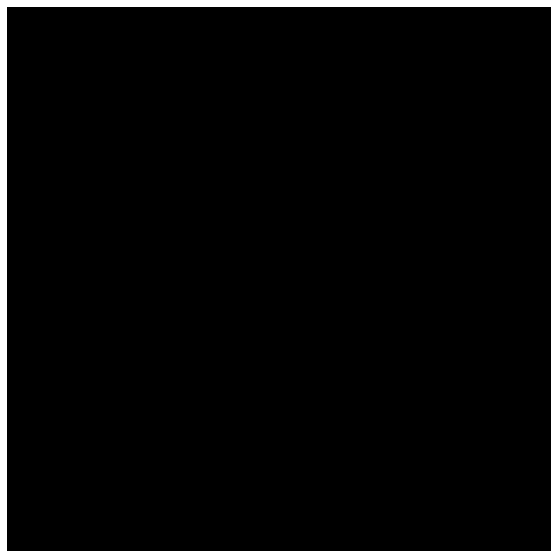

In [14]:
while current_iteration != total_iteration:
    model.train()
    try:
        data = next(dataiterator)
    except:
        dataiterator = iter(train_loader)
        data = next(dataiterator)
    # data = data[0].to(device = device)
    data = data.to(device = device)
    loss = model.loss_fn(data)
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    losses.update(loss.item())
    progress.display(current_iteration)
    current_iteration += 1
    
    if current_iteration % display_iteration == 0:
        dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, model, device, eps=eps)
        sample = dynamic.sampling(sampling_number, only_final)
        imshow(sample, sampling_number)
        losses.reset()

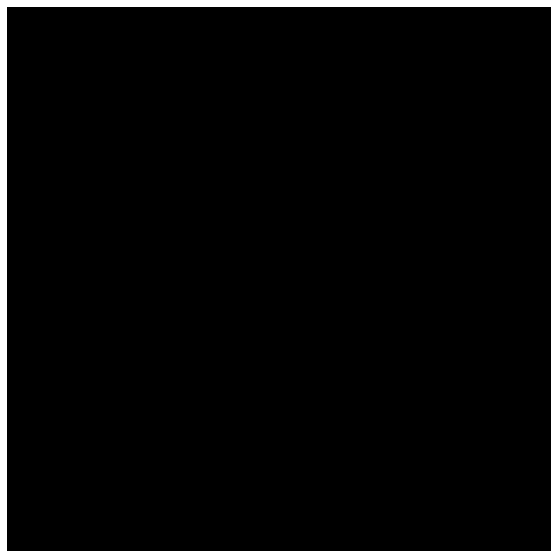

In [15]:
sampling_number = 4
only_final = True
dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, model, device, eps=eps)
sample = dynamic.sampling(sampling_number, only_final)
imshow(sample, sampling_number)

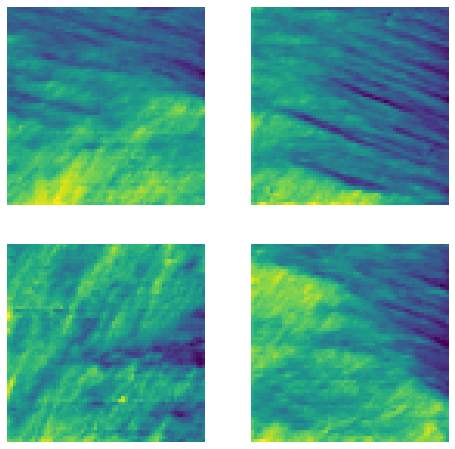

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
for i in range(2):
    for j in range(2):
        ax[i, j].imshow(sample.cpu().numpy()[i * 2 + j][0,:,:], origin="lower")
        ax[i, j].axis("off")
plt.show()